## Setting Up Your Python Environment

In [35]:
# %%capture
# # Install PyTorch
!pip install torch torchvision torchaudio

# # Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tabulate tqdm

# # Install package for creating visually distinct colormaps
!pip install distinctipy

# # Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [36]:
# Import Python Standard Library dependencies
from contextlib import contextmanager
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor, move_data_to_device
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop, RandomPixelCopy

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler

from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

# Import Keypoint R-CNN
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import keypointrcnn_resnet50_fpn

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [37]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 123
set_seed(seed)

### Setting the Device and Data Type

In [38]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cpu', torch.float32)

### Setting the Directory Paths

In [39]:
# The name for the project
project_name = f"pytorch-keypoint-r-cnn"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

dist_dir = Path("./Datasets/")
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir,
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-keypoint-r-cnn
Dataset Directory:,Datasets
Archive Directory:,Datasets/../Archive


## Loading and Exploring the Dataset

### Setting the Dataset Path

In [40]:
# Set the name of the dataset
dataset_name = 'images'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'ryaposov/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "Dataset:": hf_dataset,
    "Archive Path:": archive_path,
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

Dataset:,ryaposov/images
Archive Path:,Datasets/../Archive/images.zip
Dataset Path:,Datasets/images


### Downloading the Dataset

In [41]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://github.com/ryaposov/keypoint-rcnn-test/raw/refs/heads/main/data/{dataset_name}.zip"
annotations_url = f"https://github.com/ryaposov/keypoint-rcnn-test/raw/refs/heads/main/data/label-studio-export.json"
print(f"Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

print("Downloading dataset...")
download_file(dataset_url, archive_dir, True)
download_file(annotations_url, dist_dir, True)

print("Extracting dataset...")
file_extract(fname=archive_path, dest=dataset_path)

Dataset URL: https://github.com/ryaposov/keypoint-rcnn-test/raw/refs/heads/main/data/images.zip


  0%|          | 0.00/11.5M [00:00<?, ?iB/s]

  0%|          | 0.00/166k [00:00<?, ?iB/s]

Extracting dataset...


### Get Image File Paths

In [42]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in (img_file_paths)}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 20


,0
00c30ccb-daa3-48a6-bd32-b9d33b9ff9d7_match_thumbnail_0,Datasets/images/00c30ccb-daa3-48a6-bd32-b9d33b9ff9d7_match_thumbnail_0.jpg
009f2748-f5bf-4b99-82b7-e2c5ce95687b_match_thumbnail_0,Datasets/images/009f2748-f5bf-4b99-82b7-e2c5ce95687b_match_thumbnail_0.jpg
00d7d36b-2e74-465a-851d-d235352ca8b2_match_thumbnail_0,Datasets/images/00d7d36b-2e74-465a-851d-d235352ca8b2_match_thumbnail_0.jpg
009b5e99-6962-4c2d-8834-36d31fa9b4f5_match_thumbnail_0,Datasets/images/009b5e99-6962-4c2d-8834-36d31fa9b4f5_match_thumbnail_0.jpg
01068e1f-3965-45ce-938c-77b2a7589a2e_match_thumbnail_0,Datasets/images/01068e1f-3965-45ce-938c-77b2a7589a2e_match_thumbnail_0.jpg


### Get Image Annotations

In [43]:
# Path to the dataset and the annotations file
annotations_file = dist_dir / "label-studio-export.json"

# Load the annotations file
with open(annotations_file, 'r') as f:
    data = json.load(f)

# Extract annotations into a list of dictionaries
annotations_list = []
required_labels = ["Bottom Middle", "Bottom Service Box Left", "Bottom Service Box Right", "Bottom Service Box Middle"]

for item in tqdm(data, desc="Parsing annotations"):
    results = item.get('annotations')[0].get('result')
    image_annotations = []

    for result in results:
        # Extract keypoint and coordinates
        value = result.get('value', {})
        keypointLabel = value.get('keypointlabels')[0]

        if keypointLabel in required_labels:
            x_pixels = (value.get('x') / 100) * result.get('original_width')
            y_pixels = (value.get('y') / 100) * result.get('original_height')

            annotation = {
                'imagePath': Path(item.get('data').get('url')).stem,
                'keypoint': {
                    'label': value.get('keypointlabels')[0],
                    'points': [[x_pixels, y_pixels]],
                    'x': value.get('x'),
                    'y': value.get('y')
                }
            }
            image_annotations.append(annotation)

    # Validate that all required labels exist for the current image
    present_labels = {anno['keypoint']['label'] for anno in image_annotations}
    if all(label in present_labels for label in required_labels):
        annotations_list.extend(image_annotations)

# Convert the annotations into a DataFrame
annotation_df = pd.DataFrame(annotations_list)

# Group keypoints by image and aggregate into a list
annotation_df = annotation_df.groupby('imagePath').agg(
    keypoints=('keypoint', list)
).reset_index()

# Set the index to the image file name
annotation_df = annotation_df.set_index('imagePath')

# Filter to only include filenames present in both 'annotation_df' and 'img_dict'
img_dict = {key: img_dict[key] for key in annotation_df.index.intersection(img_dict.keys())}

# Filter annotation_df using the updated img_dict
annotation_df = annotation_df.loc[img_dict.keys()]

# Print the first 5 rows of the aggregated DataFrame
annotation_df.head()

Parsing annotations:   0%|          | 0/20 [00:00<?, ?it/s]

,keypoints
imagePath,
0003a752-63a2-449a-90f7-e8adbe65f5d3_match_thumbnail_0,"[{'label': 'Bottom Middle', 'points': [[893.3441662090995, 619.1743757422611]], 'x': 57.59794753121209, 'y': 71.0062357502593}, {'label': 'Bottom Service Box Right', 'points': [[1223.4867297016856, 392.97314444950985]], 'x': 78.88373499043749, 'y': 45.065727574485074}, {'label': 'Bottom Service Box Middle', 'points': [[846.5347491892375, 402.5010463394726]], 'x': 54.57993224946728, 'y': 46.15837687379273}, {'label': 'Bottom Service Box Left', 'points': [[476.63199650821116, 411.26450475224453]], 'x': 30.730625177834376, 'y': 47.16336063672529}]"
0033b608-42cc-4c05-bdf8-5260866c67ac_match_thumbnail_0,"[{'label': 'Bottom Middle', 'points': [[816.6920392945684, 759.7525683583508]], 'x': 52.655837478695574, 'y': 87.12758811448977}, {'label': 'Bottom Service Box Right', 'points': [[1210.7202350591597, 509.0816227151792]], 'x': 78.0606212159355, 'y': 58.3809200361444}, {'label': 'Bottom Service Box Left', 'points': [[449.28877587204124, 514.5941207490196]], 'x': 28.967683808642246, 'y': 59.01308724186004}, {'label': 'Bottom Service Box Middle', 'points': [[822.3011428285673, 510.9191220597926]], 'x': 53.017481807128775, 'y': 58.591642438049604}]"
00445969-113f-43ca-a186-4a54f64a7812_match_thumbnail_0,"[{'label': 'Bottom Middle', 'points': [[774.0905397201901, 636.0171770173961]], 'x': 49.90912570729788, 'y': 72.93774965795826}, {'label': 'Bottom Service Box Right', 'points': [[1116.206856680702, 429.77276048683655]], 'x': 71.96691532435216, 'y': 49.285867028306946}, {'label': 'Bottom Service Box Middle', 'points': [[772.8665704870973, 433.5353937601911]], 'x': 49.83021086312684, 'y': 49.71736166974669}, {'label': 'Bottom Service Box Left', 'points': [[426.7043093384762, 437.86242202454883]], 'x': 27.511560885781833, 'y': 50.21358050740239}]"
00511816-3e4d-4c33-acdf-94b34db76677_match_thumbnail_0,"[{'label': 'Bottom Middle', 'points': [[685.1733001751728, 740.0536112959288]], 'x': 44.17622825113944, 'y': 84.86853340549642}, {'label': 'Bottom Service Box Right', 'points': [[1130.7275654744888, 468.1492165781801]], 'x': 72.9031312362662, 'y': 53.68683676355276}, {'label': 'Bottom Service Box Middle', 'points': [[758.7795879422351, 467.48264314174236]], 'x': 48.92195924837106, 'y': 53.6103948557044}, {'label': 'Bottom Service Box Left', 'points': [[403.82923303914356, 466.8160697053045]], 'x': 26.036701034116284, 'y': 53.53395294785602}]"
0059875a-0b1f-4896-aa34-cbd424d18ee6_match_thumbnail_0,"[{'label': 'Bottom Middle', 'points': [[808.6065840842538, 542.1009508707108]], 'x': 52.13453153347864, 'y': 62.16754023746683}, {'label': 'Bottom Service Box Right', 'points': [[1086.56234150073, 414.46302220341283]], 'x': 70.05559906516635, 'y': 47.53016309672166}, {'label': 'Bottom Service Box Middle', 'points': [[783.1572766402293, 411.89759042612576]], 'x': 50.493699332058625, 'y': 47.23596220483093}, {'label': 'Bottom Service Box Left', 'points': [[472.56900280332457, 407.79289958246613]], 'x': 30.468665557919056, 'y': 46.76524077780575}]"


### Inspecting the Class Distribution

#### Get image classes

In [44]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['keypoints'].explode().to_frame().keypoints.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,Bottom Middle
1,Bottom Service Box Right
2,Bottom Service Box Middle
3,Bottom Service Box Left


#### Visualize the class distribution

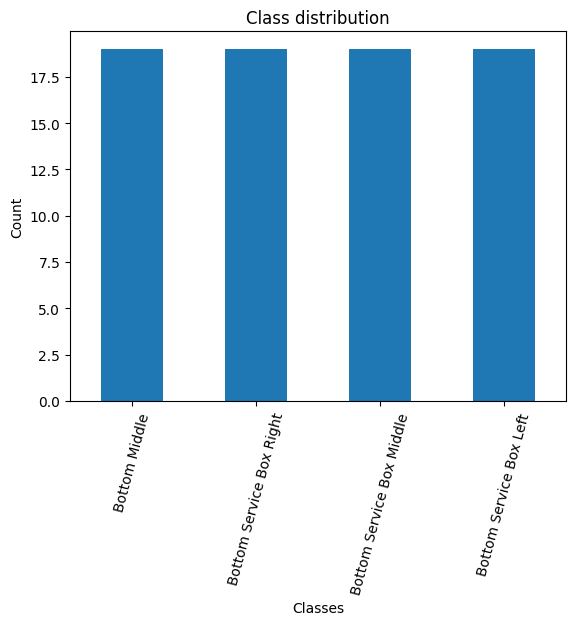

In [45]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_counts.index, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Image Annotations

#### Generate a color map

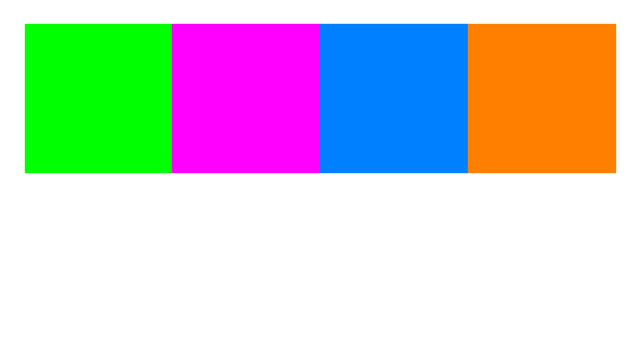

In [46]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [47]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [48]:
draw_bboxes = partial(draw_bounding_boxes, fill=True, width=4, font=font_file, font_size=25)

### Annotate sample image

In [ ]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as an RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Get image dimensions
img_width, img_height = sample_img.size

# Extract the labels and keypoint annotations for the sample image
labels = [shape['label'] for shape in annotation_df.loc[file_id]['keypoints']]
keypoints = np.array([
    [shape['x'] * img_width / 100, shape['y'] * img_height / 100]
    for shape in annotation_df.loc[file_id]['keypoints']
])
keypoints = torch.tensor(keypoints).reshape(-1, 2)

# Define bounding box dimensions
BBOX_DIM = 4
keypoints_bboxes = torch.cat((keypoints, torch.ones(len(keypoints), 2) * BBOX_DIM), dim=1)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = torchvision.utils.draw_bounding_boxes(
    image=transforms.PILToTensor()(sample_img),
    boxes=torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy'),
    labels=labels,
    colors=[int_colors[class_names.index(label)] for label in labels]
)

tensor_to_pil(annotated_tensor)

## Loading the Keypoint R-CNN Model

In [ ]:
# Load a pre-trained model
model = keypointrcnn_resnet50_fpn(weights='DEFAULT')

# Replace the classifier head with the number of keypoints
in_features = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_channels=in_features, num_keypoints=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'keypointrcnn_resnet50_fpn'

### Summarizing the Model

In [ ]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

## Preparing the Data

### Training-Validation Split

In [ ]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

### Data Augmentation

#### Set training image size

In [ ]:
# Set training image size
train_sz = 512

#### Initialize custom transforms

In [ ]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                               max_scale=1.0,
                               min_aspect_ratio=0.5,
                               max_aspect_ratio=2.0,
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400,
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

In [ ]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['keypoints']]

# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy'),
                                format='xyxy',
                                canvas_size=sample_img.size[::-1]),
           'labels': torch.Tensor([class_names.index(label) for label in labels])}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sanitized_img),
    boxes=targets['boxes'],
    labels=[class_names[int(label.item())] for label in targets['labels']],
    colors=sample_colors,
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [ ]:
class LabelMeKeypointDataset(Dataset):
    """
    A PyTorch Dataset class for handling LabelMe image keypoints.

    This class extends PyTorch's Dataset and is designed to work with image data and
    associated keypoints annotations. It supports loading images and corresponding
    keypoints annotations, and applying transformations.

    Attributes:
        img_keys (list): List of image keys.
        annotation_df (DataFrame): DataFrame containing annotations for each image.
        img_dict (dict): Dictionary mapping image keys to their file paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (callable, optional): Transformations to be applied to the images and targets.
    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the LabelMeKeypointDataset with image keys, annotations, and other relevant information.

        Args:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame containing annotations for each image.
            img_dict (dict): Dictionary mapping image keys to their file paths.
            class_to_idx (dict): Dictionary mapping class names to class indices.
            transforms (callable, optional): Transformations to be applied to the images and targets.
        """
        super(Dataset, self).__init__()

        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms
        self.sanitize_bboxes = torchvision.transforms.v2.SanitizeBoundingBoxes()

        self.BBOX_DIM = 4
        self.DUMMY_VALUE = -1

    def __len__(self):
        """
        Returns the number of items in the dataset.

        Returns:
            int: Number of items in the dataset.
        """
        return len(self._img_keys)

    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding target (annotations).
        """
        img_key = self._img_keys[index]

        # Check if the key exists in the DataFrame index
        if img_key in self._annotation_df.index:
            annotation = self._annotation_df.loc[img_key]
            image, target = self._load_image_and_target(annotation)

            # Applying transformations if specified
            if self._transforms:
                image, target = self._transforms(image, target)

            # Fill any missing keypoints with dummy values
            target = self._fill_and_order_target(target)
            return image, target
        else:
            # Handle the case where the key is not found
            print(f"Warning: Key '{img_key}' not found in annotation DataFrame. Skipping this sample.")
            # You can choose to return a default value or raise an exception here
            return None  # Or raise an exception

    def order_points_by_labels(self, data, label_order):
        """
        Extracts and orders points from a list of dictionaries based on a given order of labels.

        :param data: List of dictionaries containing labels and points.
        :param label_order: List of labels in the desired order.
        :return: List of points in the specified label order.
        """
        ordered_points = []
        label_to_points = {item['label']: item['points'] for item in data}

        for label in label_order:
            points = label_to_points.get(label)
            if points is not None:
                ordered_points.extend(points)

        return ordered_points

    def _load_image_and_target(self, annotation):
        """
        Loads an image and its corresponding target (annotations) based on the provided annotation.

        Args:
            annotation (DataFrame row): Annotation data for a specific image.
            Returns:
        tuple: A tuple containing the loaded image and its corresponding target data.
        """
        # Load the image from the file path specified in the annotations
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        # Extracting keypoints from the annotation and converting them to a tensor
        keypoints = self.order_points_by_labels(annotation['keypoints'], self._class_to_idx.keys())
        keypoints = torch.tensor(np.array(keypoints, dtype=np.float32)).reshape(-1, 2)

        # Adding an offset to create bounding boxes around keypoints
        keypoints_bboxes = torch.cat((keypoints, torch.ones(len(keypoints), 2) * self.BBOX_DIM), dim=1)

        # Convert bounding box format and create a BoundingBoxes object
        bbox_tensor = torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy')
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])

        # Create tensor for labels based on the class indices
        labels = torch.Tensor([self._class_to_idx[label] for label in self._class_to_idx.keys()])

        return image, {'boxes': boxes, 'labels': labels}

    def _fill_and_order_target(self, target):
        """
        Fills and orders the target bounding boxes and labels based on the class index.

        This method ensures that each target has a bounding box and label for each class,
        even if some classes are not present in the original target. Missing classes
        are filled with dummy values.

        Args:
            target (dict): A dictionary containing 'boxes' and 'labels' keys, where
                           'boxes' is a tensor of bounding boxes and 'labels' is a tensor
                           of labels corresponding to these boxes.

        Returns:
            dict: The updated target dictionary with boxes and labels ordered and filled
                  according to the class index.
        """

        # Initialize new boxes with dummy values for each class
        new_boxes = torch.full((len(self._class_to_idx), 4), self.DUMMY_VALUE)
        # Prepare labels tensor based on the class indices
        new_labels = torch.tensor(list(self._class_to_idx.values()), dtype=torch.float32)

        # Iterate over each class label
        for i, label in enumerate(new_labels):
            # Check if the current label exists in the target's labels
            if label in target['labels']:
                # Find the index of the current label in the target's labels
                idx = (target['labels'] == label).nonzero(as_tuple=True)[0]
                # Assign the corresponding box to the new boxes tensor
                new_boxes[i] = target['boxes'][idx]

        # Update the target dictionary with the new boxes and labels
        target['boxes'] = new_boxes
        target['labels'] = new_labels

        return target

### Image Transforms

In [ ]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        transforms.ColorJitter(
                brightness = (0.8, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        RandomPixelCopy(max_pct=0.025),
        transforms.RandomPerspective(distortion_scale=0.15, p=0.5, fill=(123, 117, 104)),
        transforms.RandomRotation(degrees=90, fill=(123, 117, 104)),
        iou_crop,
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm,
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Dataset

In [ ]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = LabelMeKeypointDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = LabelMeKeypointDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

### Inspect Samples

#### Inspect training set sample

In [ ]:
# Get a sample image and its target annotations
dataset_sample = train_dataset[0]

# Sanitize bounding boxes to remove dummy values
targets = dataset_sample[1]

targets['boxes'] = BoundingBoxes(targets['boxes'], format='xyxy', canvas_size=dataset_sample[0].shape[1:])
sanitized_image, sanitized_targets = transforms.SanitizeBoundingBoxes()(dataset_sample[0], targets)

# Annotate the sample image with the sanitized annotations
annotated_tensor = draw_bboxes(
    image=(sanitized_image*255).to(dtype=torch.uint8),
    boxes=sanitized_targets['boxes'],
    labels=[class_names[int(i.item())] for i in sanitized_targets['labels']],
    colors=[int_colors[int(i.item())] for i in sanitized_targets['labels']]
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

In [ ]:
dataset_sample = valid_dataset[0]

annotated_tensor = draw_bboxes(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [ ]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn': lambda batch: tuple(zip(*batch)),
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_dataloader)}')
print(f'Number of batches in validation DataLoader: {len(valid_dataloader)}')

## Fine-tuning the Model

### Define Utility Functions

#### Define a function to create a bounding box that encapsulates the key points

In [ ]:
def keypoints_to_bbox(keypoints, offset=10):
    """
    Convert a tensor of keypoint coordinates to a bounding box.

    Args:
    keypoints (Tensor): A tensor of shape (N, 2), where N is the number of keypoints.

    Returns:
    Tensor: A tensor representing the bounding box [xmin, ymin, xmax, ymax].
    """
    x_coordinates, y_coordinates = keypoints[:, 0], keypoints[:, 1]

    xmin = torch.min(x_coordinates)
    ymin = torch.min(y_coordinates)
    xmax = torch.max(x_coordinates)
    ymax = torch.max(y_coordinates)

    bbox = torch.tensor([xmin-offset, ymin-offset, xmax+offset, ymax+offset])

    return bbox

#### Define a conditional autocast context manager

In [ ]:
@contextmanager
def conditional_autocast(device):
    """
    A context manager for conditional automatic mixed precision (AMP).

    This context manager applies automatic mixed precision for operations if the
    specified device is not a CPU. It's a no-op (does nothing) if the device is a CPU.
    Mixed precision can speed up computations and reduce memory usage on compatible
    hardware, primarily GPUs.

    Parameters:
    device (str): The device type, e.g., 'cuda' or 'cpu', which determines whether
                  autocasting is applied.

    Yields:
    None - This function does not return any value but enables the wrapped code
           block to execute under the specified precision context.
    """

    # Check if the specified device is not a CPU
    if 'cpu' not in device:
        # If the device is not a CPU, enable autocast for the specified device type.
        # Autocast will automatically choose the precision (e.g., float16) for certain
        # operations to improve performance.
        with autocast(device_type=device):
            yield
    else:
        # If the device is a CPU, autocast is not applied.
        # This yields control back to the with-block with no changes.
        yield

### Define the Training Loop

In [ ]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.

    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.

    Returns:
        The average loss for the epoch.
    """
    # Set model to training mode
    model.train()

    # Initialize the average loss for the current epoch
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, targets) in enumerate(dataloader):

        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        # Extract the ground truth bounding boxes and labels
        gt_bboxes, gt_labels = zip(*[(d['boxes'].to(device), d['labels'].to(device)) for d in targets])

        # Convert ground truth bounding boxes from 'xyxy' to 'cxcywh' format and only keep center coordinates
        gt_keypoints = torchvision.ops.box_convert(torch.stack(gt_bboxes), 'xyxy', 'cxcywh')[:,:,:2]

        # Initialize a visibility tensor with ones, indicating all keypoints are visible
        visibility = torch.ones(len(inputs),gt_keypoints.shape[1],1).to(device)
        # Create a visibility mask based on whether the bounding boxes are valid (greater than or equal to 0)
        visibility_mask = (torch.stack(gt_bboxes) >= 0.)[..., 0].view(visibility.shape).to(device)

        # Concatenate the keypoints with the visibility mask, adding a visibility channel to keypoints
        gt_keypoints_with_visibility = torch.concat((
            gt_keypoints,
            visibility*visibility_mask
        ), dim=2)

        # Convert keypoints to bounding boxes for each input and move them to the specified device
        gt_object_bboxes = torch.vstack([keypoints_to_bbox(keypoints) for keypoints in gt_keypoints]).to(device)
        # Initialize ground truth labels as tensor of ones and move them to the specified device
        gt_labels = torch.ones(len(inputs), dtype=torch.int64).to(device)

        # Prepare the targets for the Keypoint R-CNN model
        # This includes bounding boxes, labels, and keypoints with visibility for each input image
        keypoint_rcnn_targets = [
            {'boxes' : boxes[None], 'labels': labels[None], 'keypoints': keypoints[None]}
            for boxes, labels, keypoints in zip(gt_object_bboxes, gt_labels, gt_keypoints_with_visibility)
        ]


        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with conditional_autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(keypoint_rcnn_targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(keypoint_rcnn_targets, device))

            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    progress_bar.close()
    return epoch_loss / (batch_id + 1)

In [ ]:
def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    """
    Main training loop.

    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device

    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [ ]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

### Save the Color Map

In [ ]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

### Configure the Training Parameters

In [ ]:
# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 70

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))

### Train the Model

In [ ]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/5 [00:00<?, ?it/s]

## Making Predictions with the Model

### Prepare Input Data

In [ ]:
# Choose a random item from the validation set
file_id = val_keys[0]

# Retrieve the image file path associated with the file ID
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

### Get Target Annotation Data

In [ ]:
# Extract the source annotations for the test image
gt_labels = [shape['label'] for shape in annotation_df.loc[file_id]['keypoints']]
gt_keypoints = torch.tensor(np.array([shape['points'] for shape in annotation_df.loc[file_id]['shapes']])).reshape(-1,2)
gt_keypoints_bboxes = torch.cat((gt_keypoints, torch.ones(len(gt_keypoints), 2)*BBOX_DIM), dim=1)

### Pass Input Data to the Model

In [ ]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device);
input_tensor = transforms.Compose([transforms.ToImage(),
                                   transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)[0]

### Filter the Model Output

In [ ]:
# Set the confidence threshold
conf_threshold = 0.8

# Filter the output based on the confidence threshold
scores_mask = model_output['scores'] > conf_threshold

# Extract and scale the predicted keypoints
predicted_keypoints = (model_output['keypoints'][scores_mask])[:,:,:-1].reshape(-1,2)*min_img_scale

### Compare Model Predictions with the Source Annotations

In [ ]:
# Annotate the test image with the ground-truth annotations
gt_annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(test_img),
    boxes=torchvision.ops.box_convert(torch.Tensor(gt_keypoints_bboxes), 'cxcywh', 'xyxy'),
    # labels=gt_labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in gt_labels]]
)

# Prepare the labels and bounding box annotations for the test image
labels = class_names*sum(scores_mask).item()
keypoints_bboxes = torch.cat((predicted_keypoints.cpu(), torch.ones(len(predicted_keypoints), 2)), dim=1)

# Annotate the test image with the model predictions
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(test_img),
    boxes=torchvision.ops.box_convert(torch.Tensor(keypoints_bboxes), 'cxcywh', 'xyxy'),
    # labels=labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

stack_imgs([tensor_to_pil(gt_annotated_tensor), tensor_to_pil(annotated_tensor)])